# **Extracting the Zip files**

In [1]:
import zipfile
import os

# Zip file path
zip_file_path = '/content/drive/MyDrive/train data/traindata.zip'

# extracting file directory
extract_to = 'heartrate'

# Create the directory if it doesn't exist
if not os.path.exists(extract_to):
    os.makedirs(extract_to)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Files extracted to {extract_to}")

Files extracted to heartrate


# **Step 1: Import the Necessary Libraries**

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout


# **Step 2: Load and Explore the Dataset**

In [12]:
# Load the data
freq_df = pd.read_csv('/content/heartrate/traindata/Train Data Zip/frequency_domain_features_train.csv')
non_linear_df = pd.read_csv('/content/heartrate/traindata/Train Data Zip/heart_rate_non_linear_features_train.csv')
time_df = pd.read_csv('/content/heartrate/traindata/Train Data Zip/time_domain_features_train.csv')

# Merge the datasets on 'uuid'
merged_df = pd.merge(freq_df, non_linear_df, on='uuid')
merged_df = pd.merge(merged_df, time_df, on='uuid')

# Drop the 'uuid' column and non-numeric 'condition' column
merged_df = merged_df.drop(columns=['uuid', 'condition'])

# Display first few rows of merged dataframe
print(merged_df.head())


           VLF    VLF_PCT           LF     LF_PCT      LF_NU         HF  \
0  2661.894136  72.203287  1009.249419  27.375666  98.485263  15.522602   
1  2314.265450  76.975728   690.113275  22.954139  99.695397   2.108525   
2  1373.887112  51.152225  1298.222619  48.335104  98.950472  13.769729   
3  2410.357408  70.180308  1005.981659  29.290305  98.224706  18.181913   
4  1151.177330  43.918366  1421.782051  54.242160  96.720007  48.215822   

     HF_PCT     HF_NU           TP       LF_HF  ...      KURT      SKEW  \
0  0.421047  1.514737  3686.666157   65.018055  ... -0.856554  0.335218   
1  0.070133  0.304603  3006.487251  327.296635  ... -0.408190 -0.155286   
2  0.512671  1.049528  2685.879461   94.280910  ...  0.351789 -0.656813   
3  0.529387  1.775294  3434.520980   55.328701  ... -0.504947 -0.386138   
4  1.839473  3.279993  2621.175204   29.487873  ... -0.548408 -0.154252   

   MEAN_REL_RR  MEDIAN_REL_RR  SDRR_REL_RR  RMSSD_REL_RR  SDSD_REL_RR  \
0    -0.000203      -0.00

# **Step 3: Prepare the Data for the GRU Model**

In [13]:
# Separate the features and the target (assumed 'HR' is the target)
X = merged_df.drop(columns=['HR'])
y = merged_df['HR']

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for GRU input (samples, time steps, features)
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


# **Step 4: Build the GRU Model**

In [14]:
# Build the GRU model
model = Sequential()

# Add GRU layer
model.add(GRU(units=128, return_sequences=False, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))

# Add a dropout layer to prevent overfitting
model.add(Dropout(0.2))

# Add a dense layer for output
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Display model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                          │ (None, 128)                 │          62,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,105 (246.50 KB)

 Trainable params: 63,105 (246.50 KB)

 Non-trainable params: 0 (0.00 B)

# **Step 5: Train the GRU Model**

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 4276.1924 - val_loss: 821.6794
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 489.9653 - val_loss: 63.4837
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 54.7198 - val_loss: 18.6073
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 28.7423 - val_loss: 10.8700
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 23.2086 - val_loss: 7.3418
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 20.7464 - val_loss: 5.3532
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 18.6721 - val_loss: 4.0343
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 17.8489 - val_loss: 3.3007
Epoch 9/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 17.2446 - val_loss: 2.9972
Epoch 10/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 16.4296 - val_loss: 2.2488
Epoch 11/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 15.6815 - val_loss: 2.1544
Epoch 12/50
500/500 ━━━━━━━━━━━━━

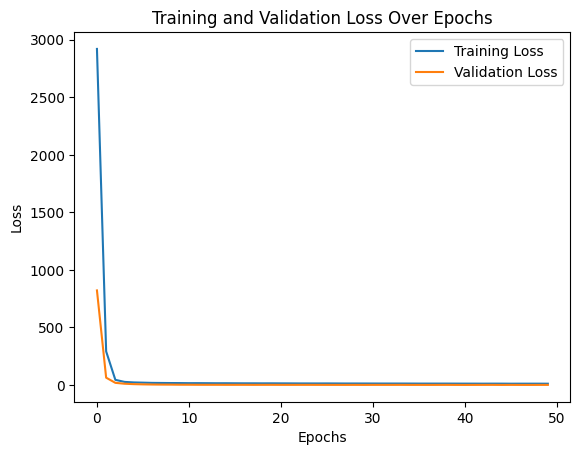

In [15]:
# Train the GRU model
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


# **Step 6: Evaluate the Model Using MSE, RMSE, and R-squared**

In [16]:
# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate the R-squared (R^2) value
r2 = r2_score(y_test, y_pred)
print(f'R-squared (R^2): {r2}')


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Mean Squared Error (MSE): 0.8454953829901894
Root Mean Squared Error (RMSE): 0.9195082288866095
R-squared (R^2): 0.9923366091090515


# **Step 7: Visualize the Results with a Scatter Plot and Line Plot**

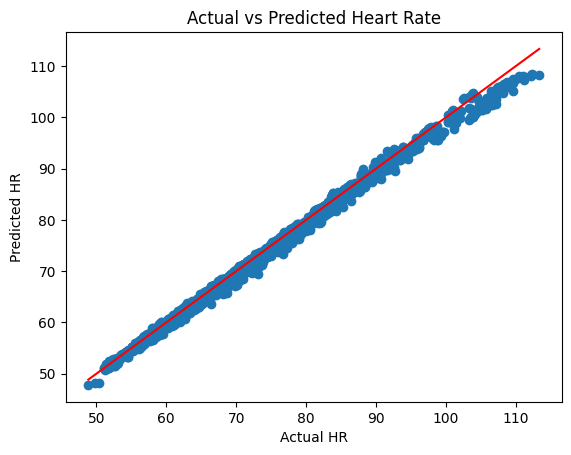

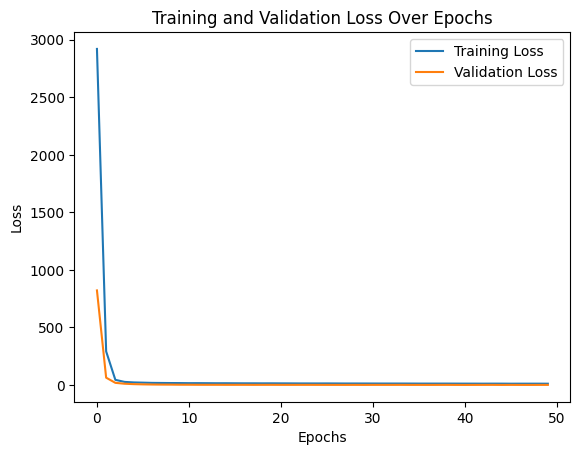

In [17]:
# Scatter plot for actual vs predicted HR
plt.scatter(y_test, y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Line showing perfect prediction
plt.xlabel('Actual HR')
plt.ylabel('Predicted HR')
plt.title('Actual vs Predicted Heart Rate')
plt.show()

# Plot training and validation loss over epochs (from step 5, but re-included here for continuity)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
